<h1>
<font color=Green>CNN Multiclass Cancer Classification Assignment</font>
</h1>

<hr>

### Author
- Prashant Mohan Sinha

<hr>

<h2>
<font color=Green>Problem Statement</font>
</h2>

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

<h2>
<font color=Green>Data Provision</font>
</h2>

We have been provided with the Skin cancer ISIC The International Skin Imaging Collaboration image data set  for the  nine classes of cancer.

<hr>

<h2>
<font color=Green>Modelling Approach</font>
</h2>

1) Create image dataset directory for Train & Test Set  <br>
2) Visualize a sample Training data for each class <br>
3) Define Network  & Run the first model <br>
4) Augment the Class Imbalance <br>
5) Model Update after Augmentation <br>
6) Model Run Observation

<hr>

<h2>
<font color=Green> <u> Important Note:</u> </font>
</h2>

CASE I: For Google COLAB runtime: switchover to GPU/TPU based runtime for faster processing. For free version account, beyond a limited use of GPU/TPU, the access to GPU may be restricted for few hours to few days. Please Google COLAB policy for more details. <br> 

https://stackoverflow.com/questions/61126851/how-can-i-use-gpu-on-google-colab-after-exceeding-usage-limit  <br>  <br>

CASE II: For Local Machine : if having NVIDIA based Graphic card, MUST configure it to tensorflow-gpu. <br> 

(https://medium.com/analytics-vidhya/installing-cuda-and-cudnn-on-windows-d44b8e9876b5#:~:text=%20Steps%20for%20installation%20%201%20Uninstall%20all,folder.%20We%20just%20need%20to%20copy...%20More%20?msclkid=c23f80d9be5911ec8b2e7b198bb3c123)  <br>

<hr>

<h3>
<font color=Green>Mount the Google Drive</font>
</h3>

In [1]:
# Uncomment the next two lines for Google Colab Run
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


<hr>
<h3>
<font color=Green>Import the Requisite Libraries</font>
</h3>

In [2]:
import pathlib
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import PIL

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

<hr>

<h3>
<font color=Green>Create Image Dataset Directory </font>
</h3>

In [3]:
# Defining the path for train and test images - GOOGLE COLAB
# Path Location - Need to change depends on the data-set locations
# Uncomment the next two lines

data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/ML/CNN_MultiClass_Classification_Cancer/data/Train/")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/ML/CNN_MultiClass_Classification_Cancer/data/Test/")

In [66]:
# # Defining the path for train and test images - Local Drive

# # # Comment this section for Google Colab Run

# data_dir_train = pathlib.Path("./data/Train") # Change the PATH Location accoording to local drive location
# data_dir_test = pathlib.Path('./data/Test') # Change the PATH Location accoording to local drive location

# print('Train Data Path: ', data_dir_train)
# print('Test Data Path: ', data_dir_test)

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [5]:
# Define Image Size & Batch Size
batchsize = 32
img_height = 180
img_width = 180

In [6]:
# Create Image Dataset Directory for Train Set
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batchsize,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# Create Image Dataset Directory for Test Set
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batchsize,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


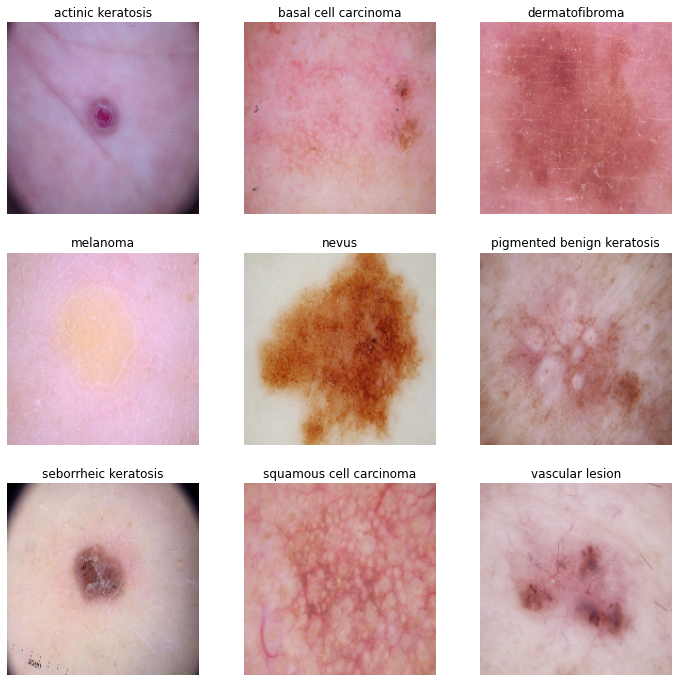

In [9]:
# Display the Image of each Class Input of Training Data Set

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [10]:
# Print the Image Size & Batch Size, & Total Labels
for image_batch, labels_batch in train_ds:
    print(labels_batch.shape)
    print(image_batch.shape)
    break

(32, 9)
(32, 180, 180, 3)


<h5>
<font color=Green>Prefetching solves the inefficiencies from naive approach as it aims to overlap the preprocessing and model execution of the training step. </font>
</h5>

In [11]:
# Prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

<h2>
<font color=Green> Model1 (Initial) </font>
</h2>

In [12]:
from tensorflow._api.v2.data import experimental

num_classes = len(class_names) # Number of accuracy
fs=3 # Filter Size

In [13]:
# Define the Initial Network Architecture as Model1

model1 = Sequential([ layers.Rescaling(scale=1./255, input_shape=(img_height,img_width,3)),
                     
  layers.Conv2D(filters=32, kernel_size= (fs,fs), padding='same', strides=1, activation='relu'),
  
  layers.MaxPooling2D(pool_size=(2,2)),
  
  layers.Conv2D(filters=64, kernel_size= (fs,fs), padding='same', strides=1, activation='relu'),
  
  layers.MaxPooling2D(pool_size=(2,2)),
  
  layers.Conv2D(filters=128, kernel_size= (fs,fs), padding='same', strides=1, activation='relu'),
  
  layers.MaxPooling2D(pool_size=(2,2)),
 
  layers.Flatten(),

  layers.Dense(128, activation='relu'),
                     
  layers.Dense(128, activation='relu'),
    
  layers.Dense(num_classes,activation='softmax')
])

# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

<h5>
    
<font color=Brown>NB:</font>
    
<font color=Black> <u> Network Architecture of Model1 is constructed (optimisation for initial run) with several trial testing of different Network testing. </u> </font>

</h5>

In [14]:
# using Categorical cross entropy loss
# choosing optimiser as adam
# metric is accuracy

# Compile the Model
model1.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [15]:
# Model Fitting
# Total number of epochs is kept limited due to contrained with system hardware. 
# It can be increased with the availibility of better hardware resource.

ep = 21 # Number of epochs to run 
history1 = model1.fit(train_ds, validation_data=val_ds, epochs=ep)

Epoch 1/21
56/56 [==============================] - 253s 1s/step - loss: 2.1286 - accuracy: 0.2316 - val_loss: 1.9814 - val_accuracy: 0.2573
Epoch 2/21
56/56 [==============================] - 2s 41ms/step - loss: 1.8682 - accuracy: 0.3008 - val_loss: 1.7443 - val_accuracy: 0.3647
Epoch 3/21
56/56 [==============================] - 2s 42ms/step - loss: 1.6728 - accuracy: 0.3990 - val_loss: 1.5400 - val_accuracy: 0.4698
Epoch 4/21
56/56 [==============================] - 2s 41ms/step - loss: 1.4699 - accuracy: 0.4721 - val_loss: 1.8122 - val_accuracy: 0.3110
Epoch 5/21
56/56 [==============================] - 2s 42ms/step - loss: 1.4556 - accuracy: 0.4799 - val_loss: 1.3959 - val_accuracy: 0.5213
Epoch 6/21
56/56 [==============================] - 2s 42ms/step - loss: 1.3003 - accuracy: 0.5363 - val_loss: 1.3666 - val_accuracy: 0.5235
Epoch 7/21
56/56 [==============================] - 2s 42ms/step - loss: 1.2094 - accuracy: 0.5631 - val_loss: 1.3672 - val_accuracy: 0.5280
Epoch 8/21
56

<h4>
<font color=Green>Visualizing training results </font>
</h4>

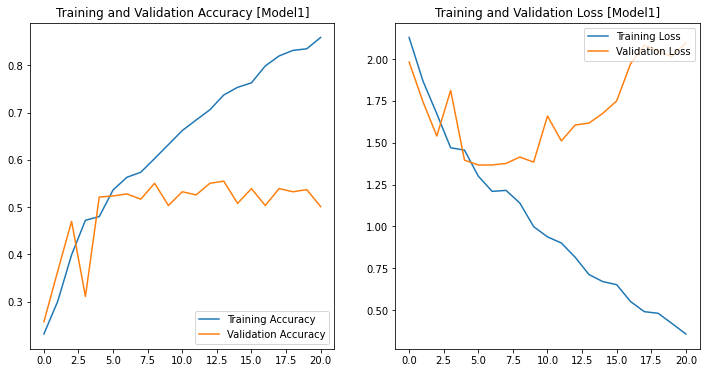

In [16]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(ep)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy [Model1]')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss [Model1]')
plt.show()

<h5>
    
<font color=Brown>Observation:</font>
    
<font color=Black>1. Plot of the Training & Validation clearly suggest the case of the overfitting. </font>
    
<font color=Black>2. Loss fuction of Training set has decreased rapidly but not so valid for validation set. A case of overfitting. </font>
    
<font color=Black>Let's first check with the dropouts & additional hidden layer in model2 and then proceed to have a look at the class distrbution of provided input set. </font>

</h5>

<h2>
<font color=Green> Model2 (Dropouts) </font>
</h2>

In [17]:
# Define the Network Architecture as Model2 with dropouts
model2 = Sequential([ layers.Rescaling(scale=1./255, input_shape=(img_height,img_width,3)),
                     
  layers.Conv2D(filters=32, kernel_size= (fs,fs), padding='same', strides=1, activation='relu'),
  
  layers.MaxPooling2D(pool_size=(2,2)),
  
  layers.Conv2D(filters=64, kernel_size= (fs,fs), padding='same', strides=1, activation='relu'),
  
  layers.MaxPooling2D(pool_size=(2,2)),
  
  layers.Dropout(0.2),
  
  layers.Conv2D(filters=128, kernel_size= (fs,fs), padding='same', strides=1, activation='relu'),
  
  layers.MaxPooling2D(pool_size=(2,2)),
                     
  layers.Dropout(0.2),
                     
  layers.Flatten(),

  layers.Dense(128, activation='relu'),

  layers.Dropout(0.3),
                     
  layers.Dense(128, activation='relu'),

  layers.Dropout(0.4),
    
  layers.Dense(num_classes,activation='softmax')
])

# View the summary of all layers
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 45, 45, 64)       

In [18]:
# using Categorical cross entropy loss
# choosing optimiser as adam
# metric is accuracy

# Compile the Model
model2.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [19]:
# Model2 Fitting
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=ep)

Epoch 1/21
56/56 [==============================] - 3s 46ms/step - loss: 2.1507 - accuracy: 0.1992 - val_loss: 2.0340 - val_accuracy: 0.2528
Epoch 2/21
56/56 [==============================] - 2s 44ms/step - loss: 1.9653 - accuracy: 0.2595 - val_loss: 1.8420 - val_accuracy: 0.3960
Epoch 3/21
56/56 [==============================] - 2s 43ms/step - loss: 1.7995 - accuracy: 0.3521 - val_loss: 1.8860 - val_accuracy: 0.3043
Epoch 4/21
56/56 [==============================] - 2s 43ms/step - loss: 1.7169 - accuracy: 0.3878 - val_loss: 1.7097 - val_accuracy: 0.4295
Epoch 5/21
56/56 [==============================] - 2s 43ms/step - loss: 1.5962 - accuracy: 0.4509 - val_loss: 1.5034 - val_accuracy: 0.5011
Epoch 6/21
56/56 [==============================] - 2s 43ms/step - loss: 1.5170 - accuracy: 0.4693 - val_loss: 1.4628 - val_accuracy: 0.5078
Epoch 7/21
56/56 [==============================] - 2s 43ms/step - loss: 1.4796 - accuracy: 0.4939 - val_loss: 1.4052 - val_accuracy: 0.5213
Epoch 8/21
56

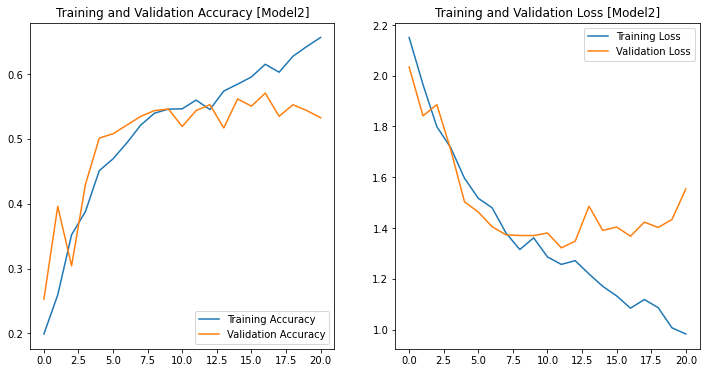

In [20]:
# Visualizing training results of Model2
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(ep)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy [Model2]')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss [Model2]')
plt.show()

<h5>
    
<font color=Brown>Observation:</font>
    
<font color=Black>1. Plot of the Training & Validation shows the reduction in overfitting issue in Model2 (by adopting dropouts) compared to Model1 (no dropouts) along with reduction in accuracy. </font>
    
<font color=Black>2. Loss function of validation set is now somewhat catching up with train set loss. Which is a minor improvement in the model2 over model1 case. </font>

<font color=Black>3. It also suugests to have the more epochs to train the noetwork for more improvment of accuracy & decrease the loss, but due to limited hardware resource, as of now it not being tested in this run. </font>
    
<font color=Black>Let's have a look at the class distrbution of provided input set for the class imbalance & use of augmentation to further refine the model2. </font>

</h5>

<h4>
<font color=Green>Plot the Class Bar Plot </font>
</h4>

In [21]:
# Count the images of each class in their sub-directories
item_count=[]
for item in class_names:
    item_count.append(len(list(data_dir_train.glob(item + '/*.jpg'))))

In [22]:
# Make DataFrame & Display the Total Counts of each Class Image
df_image_count= pd.DataFrame(list(zip(class_names, item_count)), columns =['ClassName', 'ImageCount'])
df_image_count

,ClassName,ImageCount
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


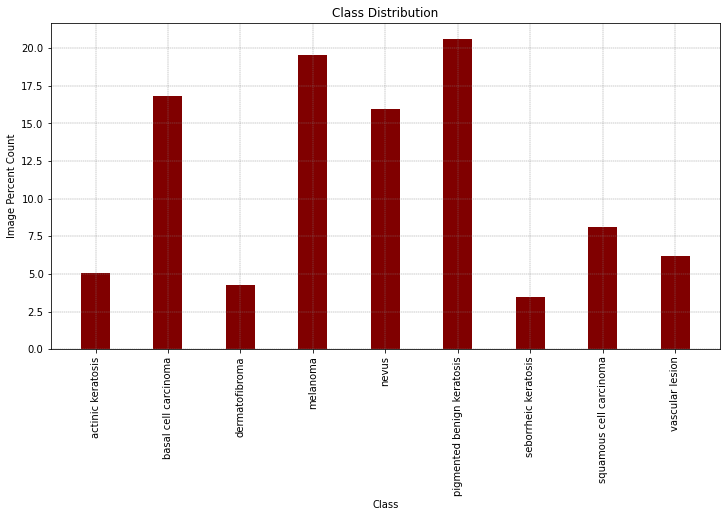

In [23]:
# Barplot of Training data set for each class

fig = plt.figure(figsize = (12, 6))
 
# creating the bar plot
plt.bar(class_names, item_count/np.sum(item_count)*100, color ='maroon',
        width = 0.4)

plt.grid(True, color = "grey", linewidth = "0.4", linestyle = "--") 
plt.xlabel("Class")
plt.ylabel("Image Percent Count")
plt.title("Class Distribution")
plt.xticks(rotation=90)
plt.show()

<h5>
<font color=Brown>Observation: </font>

<font color=Brown>1. Bar plot shows the CLass imbalance of the provided input set. </font>

<font color=Brown>2. Class `dermatofibroma` & `seborrheic keratosis` have the least number of sample set (less than 5% of total train image set). </font>

<font color=Brown>3. Class `basal cell carcinoma`, `melanoma` & `pigmented benign keratosis` dominate the sample size distribution (approx more than 18%). </font>

<font color=Brown>4. To mitigte the class imbalance we will use the `Augmentor` package.</font>

</h5>

<hr> 
<h2>
<font color=Green>Augmentor Library layer code </font>
</h2>

In [26]:
# # Install the Augmentor Package if package is not installed
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
# Path Location - Change the PATH depends on the data-set location

# Colab Path Line - Change the PATH depends on the data-set location
path_to_training_dataset='/content/drive/MyDrive/Colab Notebooks/ML/CNN_MultiClass_Classification_Cancer/data/Train/'

# # Local Drive Path - Change the PATH depends on the data-set location
#path_to_training_dataset='.\data/Train/' # Uncomment the Line for Local Run

#Import Library
import Augmentor

# Initiate Pipeline & Augment Total 500 images for each class
# Remove the earlier existing output folder for each class
# otherwise it may add up more images in the output folders

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset  + i)
    p.rotate(probability = 0.8, max_left_rotation=20, max_right_rotation=20)
    p.flip_left_right(probability=0.7)
    p.flip_top_bottom(probability=0.7)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/ML/CNN_MultiClass_Classification_Cancer/data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA754566FD0>: 100%|██████████| 500/500 [00:22<00:00, 21.92 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/ML/CNN_MultiClass_Classification_Cancer/data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA7545667D0>: 100%|██████████| 500/500 [00:22<00:00, 22.05 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/ML/CNN_MultiClass_Classification_Cancer/data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA757A719D0>: 100%|██████████| 500/500 [00:22<00:00, 22.51 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/ML/CNN_MultiClass_Classification_Cancer/data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA757924410>: 100%|██████████| 500/500 [01:46<00:00,  4.68 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/ML/CNN_MultiClass_Classification_Cancer/data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA754533210>: 100%|██████████| 500/500 [01:44<00:00,  4.77 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/ML/CNN_MultiClass_Classification_Cancer/data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA754514B50>: 100%|██████████| 500/500 [00:22<00:00, 22.10 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/ML/CNN_MultiClass_Classification_Cancer/data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA7544D4750>: 100%|██████████| 500/500 [00:53<00:00,  9.33 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/ML/CNN_MultiClass_Classification_Cancer/data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA757A59A90>: 100%|██████████| 500/500 [00:23<00:00, 21.60 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/ML/CNN_MultiClass_Classification_Cancer/data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA75791D950>: 100%|██████████| 500/500 [00:23<00:00, 21.39 Samples/s]


<h4>
<font color=Black> Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.</font>

<h4>

In [29]:
# Print the total Image set before & after Augmentation

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Previous count of image Trin set before augmentation =",image_count_train)

image_count_train_au = len(list(data_dir_train.glob('*/output/*.jpg')))
print("Previous count of image Trin set after augmentation =",image_count_train_au)

Previous count of image Trin set before augmentation = 2239
Previous count of image Trin set after augmentation = 4500


<h4>
    
<font color=Brown> Lets see the distribution of augmented data after adding new images to the original training data:</font>

</h4>

In [30]:
# Count the images of each class in their sub-directories
item_count_au=[]
folder_name_au=[]
for item in class_names:
    folder_name_au.append(list(data_dir_train.glob(item + '/output/'))) 
    item_count_au.append(len(list(data_dir_train.glob(item + '/output/*.jpg'))))

# Total Images after Augmentation
item_count_au = np.array(item_count_au) + np.array(item_count)

In [31]:
# Make DataFrame & Display the Total Counts of each Class Image after Augmentation
dfau_image_count= pd.DataFrame(list(zip(class_names, item_count_au)), columns =['ClassName', 'ImageCount_Augm'])
dfau_image_count

,ClassName,ImageCount_Augm
0,actinic keratosis,614
1,basal cell carcinoma,876
2,dermatofibroma,595
3,melanoma,938
4,nevus,857
5,pigmented benign keratosis,962
6,seborrheic keratosis,577
7,squamous cell carcinoma,681
8,vascular lesion,639


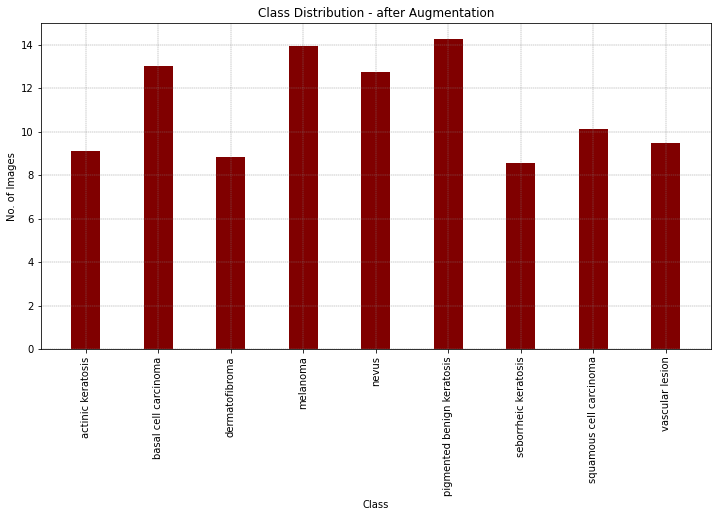

In [32]:
# Barplot of Training data set after Augmentation for each class
fig = plt.figure(figsize = (12, 6))
 
# creating the bar plot
plt.bar(class_names, item_count_au/np.sum(item_count_au)*100, color ='maroon',
        width = 0.4)

plt.grid(True, color = "grey", linewidth = "0.4", linestyle = "--") 
plt.xlabel("Class")
plt.ylabel("No. of Images")
plt.title("Class Distribution - after Augmentation")
plt.xticks(rotation=90)
plt.show()

<h5>
<font color=Brown>Observation : After Augmentation</font>

<font color=Brown>1. Bar plot shows the Class imbalance has been mitigated to some great extent. </font>

<font color=Brown>2. Class `dermatofibroma` & `seborrheic keratosis` are now more than 8% (each) of total train image set. </font>

<font color=Brown>3. Class `basal cell carcinoma`, `melanoma` & `pigmented benign keratosis` now reduced to approx 14% (each) of sample size. </font>

</h5>

<h2>
<font color=Green> Model3 </font>
</h2>

In [33]:
# Create Image Dataset Directory for Augmented Train Set

train_au_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batchsize,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [34]:
# Create Image Dataset Directory for Test Set for Augmented Train Set
val_au_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batchsize,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


<h3>
<font color=Green>Prefetching </font>
</h3>

In [35]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_au_ds = train_au_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_au_ds = val_au_ds.cache().prefetch(buffer_size=AUTOTUNE)

<h5>
    
<font color=Brown> Lets re-run the model2 network architecture on the Augmented dataset & check the accuracy. </font>
    
<h5> 

In [36]:
# Define the Network Architecture as Model3 with more increase in dropouts
model3 = Sequential([ layers.Rescaling(scale=1./255, input_shape=(img_height,img_width,3)),
                     
  layers.Conv2D(filters=32, kernel_size= (fs,fs), padding='same', strides=1, activation='relu'),
  
  layers.MaxPooling2D(pool_size=(2,2)),
  
  layers.Conv2D(filters=64, kernel_size= (fs,fs), padding='same', strides=1, activation='relu'),
  
  layers.MaxPooling2D(pool_size=(2,2)),
  
  layers.Dropout(0.2),
  
  layers.Conv2D(filters=128, kernel_size= (fs,fs), padding='same', strides=1, activation='relu'),
  
  layers.MaxPooling2D(pool_size=(2,2)),
                     
  layers.Dropout(0.2),
                     
  layers.Flatten(),

  layers.Dense(128, activation='relu'),

  layers.Dropout(0.3),
                     
  layers.Dense(128, activation='relu'),

  layers.Dropout(0.4),
    
  layers.Dense(num_classes,activation='softmax')
])

# View the summary of all layers
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 45, 45, 64)       

In [37]:
# using Categorical cross entropy loss
# choosing optimiser as adam
# metric is accuracy

# Compile the Model
model3.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [38]:
# Model Fitting with Model3 Network Architecture
ep=25
history3 = model3.fit(train_au_ds, validation_data=val_au_ds, epochs=ep)

Epoch 1/25
169/169 [==============================] - 40s 82ms/step - loss: 2.1473 - accuracy: 0.1708 - val_loss: 1.8954 - val_accuracy: 0.2554
Epoch 2/25
169/169 [==============================] - 7s 43ms/step - loss: 1.7616 - accuracy: 0.3195 - val_loss: 1.5864 - val_accuracy: 0.4180
Epoch 3/25
169/169 [==============================] - 7s 43ms/step - loss: 1.6333 - accuracy: 0.3644 - val_loss: 1.6259 - val_accuracy: 0.3912
Epoch 4/25
169/169 [==============================] - 7s 43ms/step - loss: 1.5683 - accuracy: 0.3930 - val_loss: 1.5522 - val_accuracy: 0.3846
Epoch 5/25
169/169 [==============================] - 7s 43ms/step - loss: 1.5163 - accuracy: 0.4073 - val_loss: 1.4155 - val_accuracy: 0.4410
Epoch 6/25
169/169 [==============================] - 7s 43ms/step - loss: 1.4871 - accuracy: 0.4288 - val_loss: 1.4643 - val_accuracy: 0.4410
Epoch 7/25
169/169 [==============================] - 7s 43ms/step - loss: 1.4232 - accuracy: 0.4531 - val_loss: 1.3634 - val_accuracy: 0.471

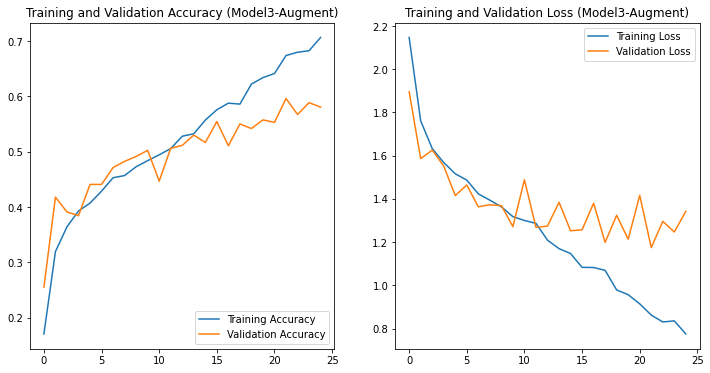

In [39]:
# Visualizing training results of Model3
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(ep)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Model3-Augment)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model3-Augment)')
plt.show()

In [40]:
# using BinaryCrossentropy loss
# choosing optimiser as adam
# metric is accuracy

# Compile the Model
model3.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [41]:
# Model Fitting with Model3 Network Architecture
ep=21
history3a = model3.fit(train_au_ds, validation_data=val_au_ds, epochs=ep)

Epoch 1/21


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 9s 44ms/step - loss: 0.2236 - accuracy: 0.6641 - val_loss: 0.2292 - val_accuracy: 0.5887
Epoch 2/21
169/169 [==============================] - 7s 43ms/step - loss: 0.1473 - accuracy: 0.7259 - val_loss: 0.2323 - val_accuracy: 0.5902
Epoch 3/21
169/169 [==============================] - 7s 43ms/step - loss: 0.1365 - accuracy: 0.7417 - val_loss: 0.2235 - val_accuracy: 0.6132
Epoch 4/21
169/169 [==============================] - 7s 43ms/step - loss: 0.1338 - accuracy: 0.7457 - val_loss: 0.2227 - val_accuracy: 0.6006
Epoch 5/21
169/169 [==============================] - 7s 43ms/step - loss: 0.1229 - accuracy: 0.7647 - val_loss: 0.2299 - val_accuracy: 0.6206
Epoch 6/21
169/169 [==============================] - 7s 43ms/step - loss: 0.1252 - accuracy: 0.7639 - val_loss: 0.2527 - val_accuracy: 0.5895
Epoch 7/21
169/169 [==============================] - 7s 43ms/step - loss: 0.1105 - accuracy: 0.7914 - val_loss: 0.2435 - val_accuracy: 0.6036
Epoch 8/21

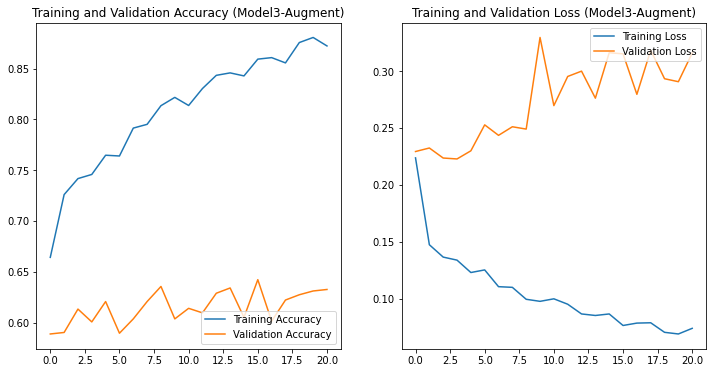

In [42]:
# Visualizing training results of Model3
acc = history3a.history['accuracy']
val_acc = history3a.history['val_accuracy']

loss = history3a.history['loss']
val_loss = history3a.history['val_loss']

epochs_range = range(ep)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Model3-Augment)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model3-Augment)')
plt.show()

In [43]:
# using KLDivergence loss
# choosing optimiser as adam
# metric is accuracy

# Compile the Model
model3.compile(
  optimizer='adam',
  loss=tf.keras.losses.KLDivergence(reduction="auto"),
  metrics=['accuracy'])

In [44]:
# Model Fitting with Model3 Network Architecture
ep=21
history3b = model3.fit(train_au_ds, validation_data=val_au_ds, epochs=ep)

Epoch 1/21
169/169 [==============================] - 9s 43ms/step - loss: 0.3712 - accuracy: 0.8709 - val_loss: 1.7449 - val_accuracy: 0.6169
Epoch 2/21
169/169 [==============================] - 7s 42ms/step - loss: 0.3618 - accuracy: 0.8748 - val_loss: 2.0071 - val_accuracy: 0.6102
Epoch 3/21
169/169 [==============================] - 7s 43ms/step - loss: 0.3540 - accuracy: 0.8752 - val_loss: 1.8146 - val_accuracy: 0.6251
Epoch 4/21
169/169 [==============================] - 7s 43ms/step - loss: 0.3732 - accuracy: 0.8707 - val_loss: 1.8286 - val_accuracy: 0.6043
Epoch 5/21
169/169 [==============================] - 7s 43ms/step - loss: 0.3004 - accuracy: 0.8945 - val_loss: 1.7464 - val_accuracy: 0.6169
Epoch 6/21
169/169 [==============================] - 7s 42ms/step - loss: 0.2934 - accuracy: 0.8937 - val_loss: 1.7555 - val_accuracy: 0.6392
Epoch 7/21
169/169 [==============================] - 7s 42ms/step - loss: 0.2842 - accuracy: 0.8995 - val_loss: 1.8237 - val_accuracy: 0.6184

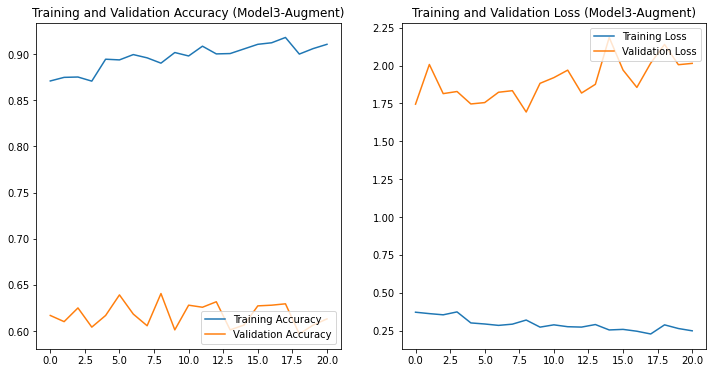

In [45]:
# Visualizing training results of Model3
acc = history3b.history['accuracy']
val_acc = history3b.history['val_accuracy']

loss = history3b.history['loss']
val_loss = history3b.history['val_loss']

epochs_range = range(ep)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Model3-Augment)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model3-Augment)')
plt.show()

<h4>
<font color=Green>Accepted Model Run Plot: Loss Function - 'CategoricalCrossentropy' :</font>
<h4>

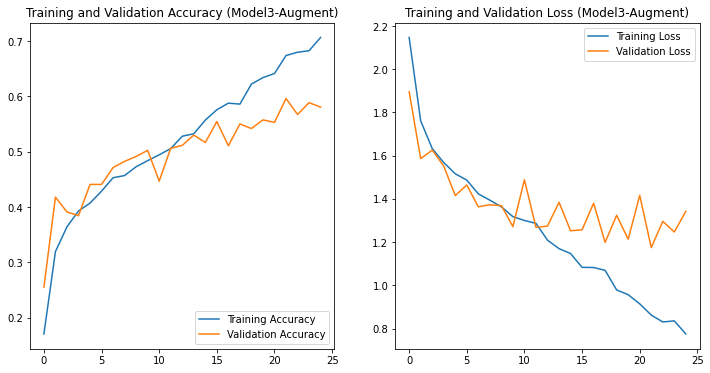

In [62]:
# Visualizing training results of Model3: Loss Function - 'CategoricalCrossentropy'
ep=25
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(ep)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Model3-Augment)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model3-Augment)')
plt.show()

<h4>
<font color=Green>Model Run Observations:</font>

<font color=Blue>1. In all the Models, optimiser is choosen as 'adam' as the preferred optimiser.  </font>

<font color=Blue>2. Model 1 is the overfiited model, after introduction of droputs in the network, the overfitting issue is Model2 considerably reduced but have the impact on accuracy. Loss & Accuracy plot suugest to introduce more epochs.</font>

<font color=Blue>3. Since data has class imbalance, Augmentor is used on. for Model3 run, which is the improvement over the previous models.</font>

<font color=Blue>4. Multiple loss functions has been tested on the Model3 Network Architecture such as 'CategoricalCrossentropy', 'BinaryCrossentropy', & 'KLDivergence', among these loss test 'CategoricalCrossentropy' is providing the optimum result. </font>
    
<font color=Blue>5. The Accepted Final model with Loss Function 'CategoricalCrossentropy' with optimser 'adam' may still have the option to futher fine tune the modelling objective, to reduce the overfitting issue along with cross checking on the unseen test data set.</font>
    
</h4>